In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import datetime
import requests
from tqdm import tqdm

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.deterministic import Fourier
from statsmodels.tsa.tsatools import add_trend
import statsmodels.api as sm
import holidays

from watermark import watermark

print(watermark())

Last updated: 2024-09-03T19:08:19.618548+03:00

Python implementation: CPython
Python version       : 3.12.5
IPython version      : 8.21.0

Compiler    : GCC 14.2.1 20240817
OS          : Linux
Release     : 6.10.7-gentoo
Machine     : x86_64
Processor   : AMD Ryzen 9 5950X 16-Core Processor
CPU cores   : 32
Architecture: 64bit



## Загрузка данных

In [2]:
time_history_url = "https://deepstatemap.live/api/history/public"

In [3]:
# Making a get request
response = requests.get(time_history_url)

df = pd.DataFrame()
# print json content
t = len(response.json())
Path("data/").mkdir(exist_ok=True)
with tqdm(total=t) as pbar:
    for n, i in enumerate(response.json()):
        timestamp = i["id"]
        time_index = datetime.datetime.fromtimestamp(timestamp)
        pbar.set_description(str(time_index.date()), refresh=True)
        area = requests.get(
            f"https://deepstatemap.live/api/history/{timestamp}/areas")
        js_df = pd.json_normalize(area.json()).assign(time_index=time_index)
        df = pd.concat([df, js_df], ignore_index=True)
        pbar.update(1)
df

2024-09-02: 100%|██████████| 1028/1028 [03:52<00:00,  4.41it/s]


,hash,area,percent,type,time_index
0,#a52714,63864.643990,10.579,occupied_after_24_02_2022,2022-04-03 15:33:28
1,#880e4f,46937.208199,7.775,occupied_to_24_02_2022,2022-04-03 15:33:28
2,#bcaaa4,5587.522472,0.926,unspecified,2022-04-03 15:33:28
3,#0f9d58,14012.882652,2.321,liberated,2022-04-03 15:33:28
4,#a52714,63864.643990,10.579,occupied_after_24_02_2022,2022-04-03 19:46:15
...,...,...,...,...,...
5261,#ff5252,139991.513798,23.189,other_territories,2024-09-02 23:32:59
5262,#880e4f,43974.128584,7.284,occupied_to_24_02_2022,2024-09-02 23:32:59
5263,#a52714,65859.476933,10.909,occupied_after_24_02_2022,2024-09-02 23:32:59
5264,#bdbdbd,337.618695,0.056,other_territories,2024-09-02 23:32:59


In [4]:
df.set_index("time_index", inplace=True)
df = df.astype(
    {"percent": "float32", "area": "float64", "hash": "string", "type": "category"}
)

In [5]:
df.to_csv(Path("data/area_history.csv"))

# Моделирование краткосрочного момента


In [6]:
try:
    df
except NameError:
    df = None
if df is None:
    td = (
        datetime.datetime.now().timestamp()
        - Path("data/area_history.csv").stat().st_ctime
    )
    if td >= 60 * 60 * 24:
        print("Данные устарели!")
    df = pd.read_csv(
        Path("data/area_history.csv"),
        index_col="time_index",
        parse_dates=True,
        dtype={
            "percent": "float32",
            "area": "float64",
            "hash": "string",
            "type": "category",
        },
    )

In [7]:
df

,hash,area,percent,type
time_index,,,,
2022-04-03 15:33:28,#a52714,63864.643990,10.579000,occupied_after_24_02_2022
2022-04-03 15:33:28,#880e4f,46937.208199,7.775000,occupied_to_24_02_2022
2022-04-03 15:33:28,#bcaaa4,5587.522472,0.926000,unspecified
2022-04-03 15:33:28,#0f9d58,14012.882652,2.321000,liberated
2022-04-03 19:46:15,#a52714,63864.643990,10.579000,occupied_after_24_02_2022
...,...,...,...,...
2024-09-02 23:32:59,#ff5252,139991.513798,23.188999,other_territories
2024-09-02 23:32:59,#880e4f,43974.128584,7.284000,occupied_to_24_02_2022
2024-09-02 23:32:59,#a52714,65859.476933,10.909000,occupied_after_24_02_2022


In [8]:
area_dinamic = (
    df.dropna()
    .groupby([pd.Grouper(freq="D"), "type"])[["area", "percent"]]
    .mean()
    .reset_index()
    .set_index("time_index")
)
last_date = df.index.max().strftime("%Y-%m-%d %X")

/tmp/ipykernel_28244/3457041684.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby([pd.Grouper(freq="D"), "type"])[["area", "percent"]]


In [9]:
occupied_by_ua = (
    df[
        (df["type"] == "other_territories") &
        (df['hash'] == '#01579b')
    ]
    .groupby(pd.Grouper(freq="D"))[["area", "percent"]]
    .mean()
)
occupied_by_ua

,area,percent
time_index,,
2024-08-08,142.989574,0.024
2024-08-09,142.989574,0.024
2024-08-10,142.989574,0.024
2024-08-11,142.989574,0.024
2024-08-12,313.306949,0.052
2024-08-13,313.483165,0.052
2024-08-14,469.022292,0.078
2024-08-15,507.762966,0.084
2024-08-16,532.395801,0.088


In [10]:
area_dinamic.dropna(inplace=True)
area_dinamic["type"]

time_index
2022-04-03                    liberated
2022-04-03    occupied_after_24_02_2022
2022-04-03       occupied_to_24_02_2022
2022-04-03                  unspecified
2022-04-04                    liberated
                        ...            
2024-09-02                    liberated
2024-09-02    occupied_after_24_02_2022
2024-09-02       occupied_to_24_02_2022
2024-09-02            other_territories
2024-09-02                  unspecified
Name: type, Length: 3994, dtype: category
Categories (5, object): ['liberated', 'occupied_after_24_02_2022', 'occupied_to_24_02_2022', 'other_territories', 'unspecified']

In [11]:
area_dinamic["type"].unique()

['liberated', 'occupied_after_24_02_2022', 'occupied_to_24_02_2022', 'unspecified', 'other_territories']
Categories (5, object): ['liberated', 'occupied_after_24_02_2022', 'occupied_to_24_02_2022', 'other_territories', 'unspecified']

In [12]:
ru_holidays = holidays.country_holidays("RU")
ua_holidays = holidays.country_holidays("UA")

In [13]:
target_area = 118370
svo_end = pd.to_datetime("2026-11-15")

In [14]:
aa = area_dinamic[area_dinamic["type"] == "occupied_after_24_02_2022"][
    "area"
]  # ["percent"]
aa = pd.DataFrame(
    index=pd.date_range(start=aa.index.min(), end=aa.index.max(), freq="D")
).join(aa)
aa.interpolate(inplace=True)
aa["prefix"] = 0
aa.loc[:"2022-11-11", "prefix"] = 1
aa

,area,prefix
2022-04-03,63714.938326,1
2022-04-04,64256.540524,1
2022-04-05,64193.626525,1
2022-04-06,64261.353774,1
2022-04-07,65046.306239,1
...,...,...
2024-08-29,65790.646995,0
2024-08-30,65817.571668,0
2024-08-31,65836.247481,0
2024-09-01,65840.718618,0


In [15]:
aa['area'] = aa['area'].subtract(occupied_by_ua['area'], fill_value=0)
aa

,area,prefix
2022-04-03,63714.938326,1
2022-04-04,64256.540524,1
2022-04-05,64193.626525,1
2022-04-06,64261.353774,1
2022-04-07,65046.306239,1
...,...,...
2024-08-29,64966.654893,0
2024-08-30,64993.579565,0
2024-08-31,65012.255378,0
2024-09-01,64933.214370,0


In [16]:
best_ff = None
best_aic = 99e99
for order in range(1, 3):
    for period in np.linspace(order * 2, 2 * 365.25, 100):
        fourier_gen = Fourier(period, order)
        ff = fourier_gen.in_sample(aa.index)
        ff["prefix"] = aa["prefix"]
        ff = add_trend(ff, "ct")
        model = sm.OLS(aa["area"], ff).fit()
        if best_ff is None or best_aic > model.aic:
            best_ff = model
best_ff.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   area   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     755.0
Date:                Tue, 03 Sep 2024   Prob (F-statistic):               0.00
Time:                        19:12:15   Log-Likelihood:                -8110.4
No. Observations:                 884   AIC:                         1.623e+04
Df Residuals:                     877   BIC:                         1.627e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
sin(1,730.50)   847.7175    138.798      6.108      0.000     575.303    1120.132
cos(1,730.50)  2753.3497    211.879     12.995      0.000    2337.501    3169.198
sin(2,730.50)  2329.5021    132.532     17.577      0.000    2069.386    2589.618
cos(2,730.50)  -591.9811    130.700     -4.529      0.000    -848.503    -335.459
prefix         2946.8775    603.795      4.881      0.000    1761.826    4131.929
const           7.19e+04    514.706    139.682      0.000    7.09e+04    7.29e+04
trend           -12.4878      0.898    -13.901      0.000     -14.251     -10.725
==============================================================================
Omnibus:                      341.839   Durbin-Watson:                   0.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2684.341
Skew:                          -1.551   Prob(JB):                         0.00
Kurtosis:                      10.953   Cond. No.                     5.25e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.25e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<Axes: >

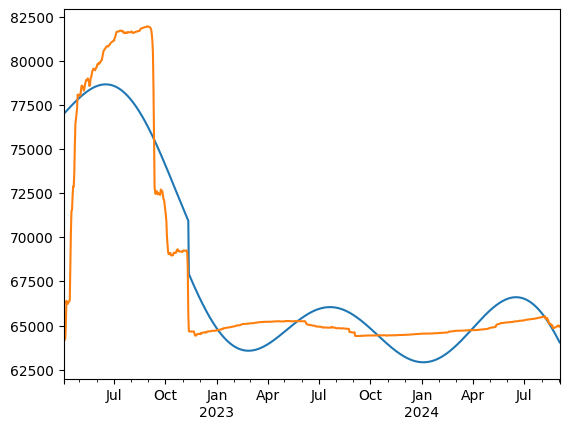

In [17]:
best_ff.predict(ff).plot()
aa["area"].plot()

In [18]:
aa.loc["2022-02-03":]

,area,prefix
2022-04-03,63714.938326,1
2022-04-04,64256.540524,1
2022-04-05,64193.626525,1
2022-04-06,64261.353774,1
2022-04-07,65046.306239,1
...,...,...
2024-08-29,64966.654893,0
2024-08-30,64993.579565,0
2024-08-31,65012.255378,0
2024-09-01,64933.214370,0


In [19]:
xx = (
    pd.DataFrame(index=aa.index).assign(
        ru_holiday=lambda x: [d in ru_holidays for d in x.index],
        ua_holiday=lambda x: [d in ua_holidays for d in x.index],
    )
).astype("int")

xx = add_trend(xx, "ct")
xx

,ru_holiday,ua_holiday,const,trend
2022-04-03,0,0,1.0,1.0
2022-04-04,0,0,1.0,2.0
2022-04-05,0,0,1.0,3.0
2022-04-06,0,0,1.0,4.0
2022-04-07,0,0,1.0,5.0
...,...,...,...,...
2024-08-29,0,0,1.0,880.0
2024-08-30,0,0,1.0,881.0
2024-08-31,0,0,1.0,882.0
2024-09-01,0,0,1.0,883.0


In [20]:
best_model = None
for p in range(6):
    for q in range(6):
        mod = ARIMA(aa["area"], order=(p, 1, q)).fit()
        if best_model is None or best_model.aic > mod.aic:
            best_model = mod
best_model.summary()

/home/v_0ver/venv/myds312/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/v_0ver/venv/myds312/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/v_0ver/venv/myds312/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/v_0ver/venv/myds312/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/v_0ver/venv/myds312/lib/python3.12/site-packag

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   area   No. Observations:                  884
Model:                 ARIMA(4, 1, 4)   Log Likelihood               -5781.396
Date:                Tue, 03 Sep 2024   AIC                          11580.793
Time:                        19:12:25   BIC                          11623.843
Sample:                    04-03-2022   HQIC                         11597.253
                         - 09-02-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3676      0.067     20.412      0.000       1.236       1.499
ar.L2         -1.1961      0.081    -14.787      0.000      -1.355      -1.038
ar.L3          1.1796      0.054     21.860      0.000       1.074       1.285
ar.L4         -0.3699      0.028    -13.379      0.000      -0.424      -0.316
ma.L1         -0.6147      0.069     -8.957      0.000      -0.749      -0.480
ma.L2          0.4763      0.041     11.535      0.000       0.395       0.557
ma.L3         -0.6392      0.035    -18.095      0.000      -0.708      -0.570
ma.L4         -0.1292      0.038     -3.377      0.001      -0.204      -0.054
sigma2      2.578e+04    261.634     98.543      0.000    2.53e+04    2.63e+04
===================================================================================
Ljung-Box (L1) (Q):                   6.10   Jarque-Bera (JB):            147554.64
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.01   Skew:                            -2.79
Prob(H) (two-sided):                  0.00   Kurtosis:                        66.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
fh = 120  # int(365.25 * 5)
fcst = best_model.get_forecast(fh, alpha=0.05).summary_frame()
fcst.index = pd.date_range(
    start=aa.index.max() + pd.DateOffset(days=1), periods=fcst.shape[0], freq="D"
)
fcst

/home/v_0ver/venv/myds312/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


area,mean,mean_se,mean_ci_lower,mean_ci_upper
2024-09-03,64988.153634,160.568790,64673.444589,65302.862679
2024-09-04,65010.838229,324.043098,64375.725427,65645.951031
2024-09-05,65005.481164,463.363433,64097.305525,65913.656804
2024-09-06,64995.549103,575.562568,63867.467200,66123.631007
2024-09-07,65001.750554,677.995521,63672.903751,66330.597358
...,...,...,...,...
2024-12-27,64872.993106,6591.149314,51954.577833,77791.408379
2024-12-28,64872.626283,6632.491341,51873.182128,77872.070439
2024-12-29,64872.266620,6673.689222,51792.076101,77952.457140
2024-12-30,64871.914326,6714.743940,51711.258037,78032.570614


In [22]:
svo_end_alpha = 99.95
svo_end_km_ration = 0.01
hh = fcst[["mean", "mean_se"]].diff() / fcst[["mean", "mean_se"]].abs()
end_svo = hh[
    (hh["mean_se"] <= 1 - svo_end_alpha /
     100) & (hh["mean"] <= svo_end_km_ration / 100)
].index.min()
fcst = fcst[:end_svo]
# fh = fcst.shape[0]
fh = 90

In [23]:
aa

,area,prefix
2022-04-03,63714.938326,1
2022-04-04,64256.540524,1
2022-04-05,64193.626525,1
2022-04-06,64261.353774,1
2022-04-07,65046.306239,1
...,...,...
2024-08-29,64966.654893,0
2024-08-30,64993.579565,0
2024-08-31,65012.255378,0
2024-09-01,64933.214370,0


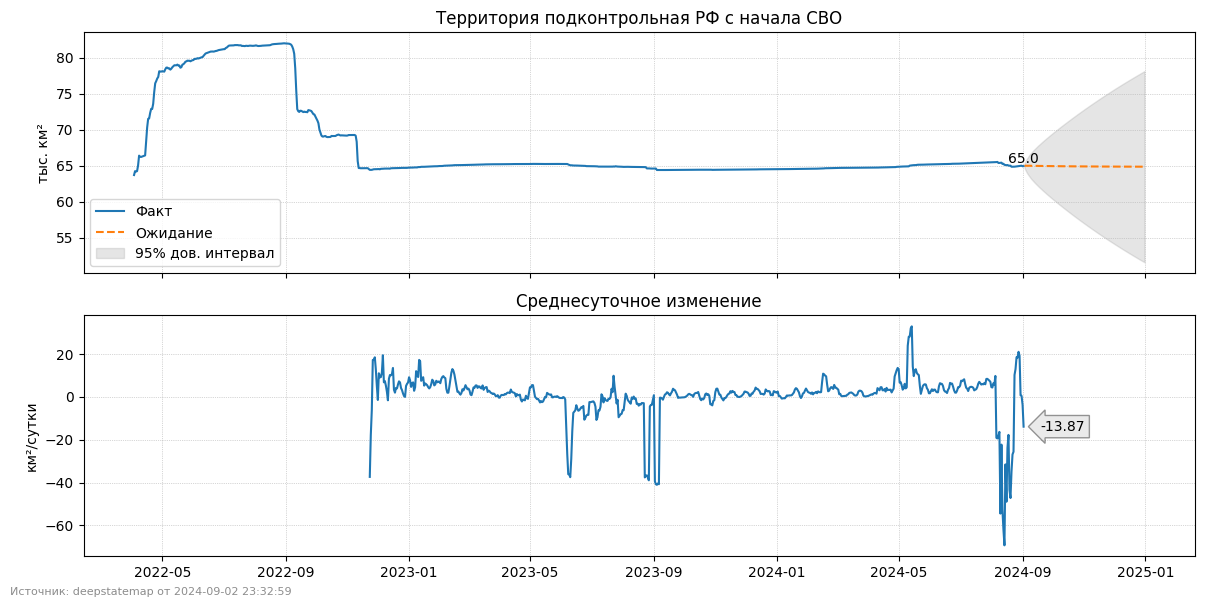

In [31]:
# sns.set_style("whitegrid")
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(12, 6))
ax = axs[0]
sns.lineplot(aa["area"] / 1000, ax=ax, label="Факт")
sns.lineplot(fcst["mean"] / 1000, ls="--", ax=ax, label="Ожидание")
fill_95p = ax.fill_between(
    fcst.index,
    fcst["mean_ci_lower"] / 1000,
    fcst["mean_ci_upper"] / 1000,
    alpha=0.2,
    color="grey",
)
fill_95p.set_label("95% дов. интервал")
ax.legend()
ax.set(
    xlabel=None,
    ylabel="тыс. км\u00b2",
    title="Территория подконтрольная РФ с начала СВО",
)
ax.text(aa['area'].index.max(), aa['area'].iloc[-1] /
        1000, f'{aa['area'].iloc[-1]/1000:.1f}', ha='center', va='bottom')
ax = axs[1]
ax.set(
    xlabel=None,
    ylabel="км\u00b2/сутки",
    title="Среднесуточное изменение",
)
day_din_area = (
    aa.diff()["2022-11-23":].rolling(5, center=True,
                                     min_periods=int(5 / 2)).mean()
)
sns.lineplot(
    day_din_area["area"],
    ax=ax,
    legend=None,
)
bbox = dict(boxstyle="larrow", fc="0.8", alpha=0.4)
dy = day_din_area.iloc[-1].values[0]
dx = day_din_area.index.max()
ax.annotate(
    f"{dy:.2f}",
    (dx + datetime.timedelta(days=16 + int(fh / 60)), dy),
    # xytext=(-2, 1),
    bbox=bbox,
    va="center",
    ha="left",
)
for ax in axs:
    ax.grid(ls=":", lw=0.5)
fig.tight_layout()
fig.text(
    0,
    0,
    f"Источник: deepstatemap от {last_date}",
    fontdict={"size": 8},
    alpha=0.45,
)
Path("img/").mkdir(exist_ok=True)
fig.savefig(Path("img/area.png"), format="png", dpi=300)